### The Emergence of Cooperation in the Spatial Prisoner's Dilemma and Snowdrift Dilemma
Noah Rivkin and Changjun Lim

In [61]:
import networkx as nx
import numpy as np


class SpatialNetwork():
    def __init__(self, n, k, graph_type='regular', dep = None, snowdrift=False):
        """creates spatial network"""
        self.n = n
        self.k = k
        self.dep = dep
        self.G = self.create_graph(graph_type)

    def create_graph(self, graph_type):
        if graph_type == 'lattice':
            return self.create_lattice()
        elif graph_type == 'powerlaw':
            return nx.powerlaw_cluster_graph(self.n, self.k, 0)
        elif graph_type == 'HK':
            if self.dep != None:
                return nx.powerlaw_cluster_graph(self.n, self.k, self.dep)
            else:
                return nx.powerlaw_cluster_graph(self.n, self.k, .3)
        G = self.create_regular()
        if graph_type == 'regular':
            return G
        elif graph_type == 'WS':
            return self.rewire(G, p=.3)
        elif graph_type == 'random':
            return self.rewire(G, p=1)
        else:
            raise ValueError('not a recognized graph type')

    def create_regular(self):
        """
        creates regular graph. Is a helper function for rewired graphs. Some
        code taken from/based on jupyter notebook chap3, credit to Allen Downey
        """
        G = nx.Graph()
        quo, rem = divmod(self.k, 2)
        nodes = list(range(self.n))
        G.add_nodes_from(nodes)
        G.add_edges_from(adjacent_edges(nodes, quo))
        # if k is odd, add opposite edges
        if rem:
            if self.n%2:
                msg = "Can't make a regular graph if n and k are odd."
                raise ValueError(msg)
            G.add_edges_from(opposite_edges())
        return G

    def create_lattice(self):
        """
        creates a lattice graph with n nodes that is k long
        """
        G = nx.Graph()
        nodes = list(range(self.n))
        G.add_nodes_from(nodes)
        for node in nodes:
            if node + self.k in nodes:
                G.add_edge(node, node + self.k)
            if node % self.k != (self.k-1) and node + 1 in nodes:
                G.add_edge(node, node + 1)
        return G

    def rewire(self, G, p):
        """Rewires each edge with probability `p`.
        code taken from/based on jupyter notebook chap3, credit to Allen Downey
        G: Graph
        p: float
        """
        if self.dep != None:
            p = self.dep
        rewire_num = p*self.k*self.n/2
        chosen = []
        nodes_down = []
        for _ in range(int(rewire_num - .5)): # int rounds down, so it removes right number
            edge = random.choice(list(G.edges))
            u, v = edge
            G.remove_edge(u, v)
            chosen.append((u,v))
            nodes_down.append(u)
            nodes_down.append(v)
        need_replace = [node for node in G.nodes if len(list(G.neighbors(node))) < self.k]
        invalid = []
        while len(need_replace) > 1:
            np.random.shuffle(need_replace)
            start = need_replace.pop()
            found = False
            for i, node in enumerate(need_replace):
                if not found:
                    pos1 = (start, node)
                    pos2 = (node, start)
                    if pos1 not in G.edges and pos2 not in G.edges and pos1 not in chosen and pos2 not in chosen:
                        found = True
                        G.add_edge(start, node)
            if found == False:
                invalid.append(start)
            need_replace = [node for node in G.nodes if len(list(G.neighbors(node))) < self.k \
                            and node not in invalid]
        return G

    
def adjacent_edges(nodes, halfk):
    """
    code taken from/based on jupyter notebook chap3, credit to Allen Downey
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

def opposite_edges(nodes):
    """Enumerates edges that connect opposite nodes.
    code taken from/based on jupyter notebook chap3, credit to Allen Downey
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        j = i + n//2
        v = nodes[j % n]
        yield u, v
        
local_test = SpatialNetwork(10,4,graph_type='WS')

In [4]:
class Node:
    C, D = 1, 0
    T, R, P, S = 3, 1, 0, 0

    def __init__(self, state: str):
        """
        node object in graph. state is C or D
        """
        self.state = state
        self.score = 0  # will hold value calculated based on prisoners dilemma

    @classmethod
    def is_cooperator_state(cls, state):
        return state == cls.C

    def is_cooperator(self):
        return self.is_cooperator_state(self.state)

    def add_score(self, score: int):
        self.score += score

    def reset_score(self):
        self.score = 0

    # Play a single PD with neighbors, and calculate score
    #  neighbors: The list of Node object
    def play_pd(self, neighbors):
        self.reset_score()
        neighbor_scores = [neighbor.state for neighbor in neighbors]
        self.add_score(self.pd_scores(neighbor_scores))
        #for neighbor in neighbors:
        #    self.add_score(self.pd_score(neighbor.state))

    # calculate single PDs scores for a node.
    def pd_scores(self, scores):
        num = len(scores)
        cnum = sum(scores)
        if self.is_cooperator():
            return cnum * Node.R + (num - cnum) * Node.S
        else:
            return cnum * Node.T + (num - cnum) * Node.P    
        
    # play single PD
    # not used
    def pd_score(self, neighbor_state):
        if self.is_cooperator():
            if self.is_cooperator_state(neighbor_state):
                return Node.R
            return Node.S
        else:
            if self.is_cooperator_state(neighbor_state):
                return Node.T
            return Node.P

    # Copy the state of the most successful neighbor
    def get_max_state(self, neighbors):
        neighbors.append(self)
        max_score = max([neighbor.score for neighbor in neighbors])
        self.max_state = [neighbor.state for neighbor in neighbors if neighbor.score == max_score]
    
    def update_state(self):
        self.state = self.max_state[0]
        
    @classmethod
    def change_rule(cls, T, R, P, S):
        cls.T, cls.R, cls.P, cls.S = T, R, P, S

In [5]:
import random
import matplotlib.pyplot as plt
import numpy as np

class TestBench:
    def __init__(self, n, k, graph_type, c0, p=None, N=100, M=10):
        self.n = n # the number of nodes
        self.graph = SpatialNetwork(n, k, graph_type, dep=p).G
        self.c0 = c0 # initial cooperator ratio
        self.N = N # the number of steps
        self.M = M # the number of test
        self.ratio = list()
        self.nodes = list()
        self.initialize()
    
    def initialize(self):
        cooperators = random.sample(range(self.n), int(self.n * self.c0))
        self.nodes = [Node(Node.C) if i in cooperators else Node(Node.D) for i in range(self.n)]
        self.ratio = list()
    
    def step(self):
        # play a single PD
        for i in range(self.n):
            neighbor = [self.nodes[key] for key in self.graph[i]]
            self.nodes[i].play_pd(neighbor)

        # get the highest neighbors' state
        for i in range(self.n):
            neighbor = [self.nodes[key] for key in self.graph[i]]
            self.nodes[i].get_max_state(neighbor)

        # update the state
        for i in range(self.n):
            self.nodes[i].update_state()

        c_ratio = len([node for node in self.nodes if node.is_cooperator()]) / self.n
        self.ratio.append(c_ratio)
    
    def iterate(self):
        ratios = np.zeros((self.M, self.N))
        for i in range(self.M):
            self.initialize()
            for _ in range(self.N):
                self.step()
            ratios[i] = self.ratio
        self.ratio = np.average(ratios, axis=0)
            
    def draw(self):
        x = range(1, len(self.ratio)+1)
        plt.plot(x, self.ratio*100)
        plt.xlabel('time')
        plt.ylabel('% C')
        plt.ylim(0,100)
        plt.show()
        
def time_ratio_graph(n, k, graph_type, c0, N, p=None, M=10, T=1, R=0.25, P=0, S=0):
    Node.change_rule(T, R, P, S)
    bench = TestBench(n, k, graph_type, c0, p, N, M)
    bench.iterate()
    bench.draw()

The proportion of cooperators in the spatial PD with d=1(regular graph)
(Fig 2 in paper)

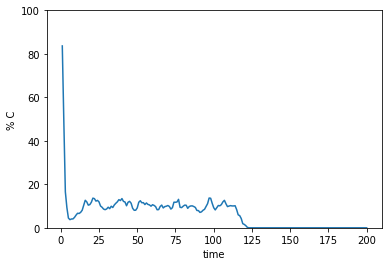

In [65]:
time_ratio_graph(n=3600, k=8, graph_type='WS', c0=0.98, N=200, M=1, T=1.99, R=1, P=0, S=0)
#time_ratio_graph(n=3600, k=8, graph_type='regular', c0=0.98, N=150, M=1, T=2, R=1, P=0, S=0)
#time_ratio_graph(n=3600, k=8, graph_type='regular', c0=0.98, N=150, M=1, T=2.1, R=1, P=0, S=0)

The proportion of cooperators in the spatial PD with d=2(lattice graph)
(Fig 2 in paper)

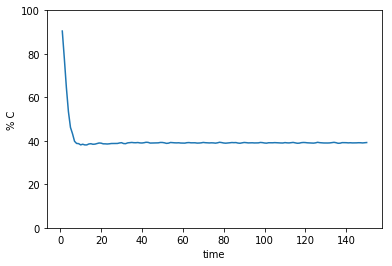

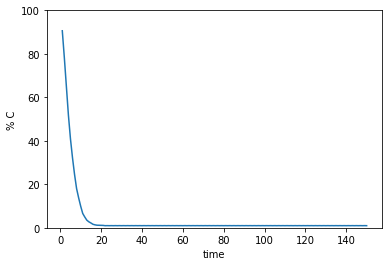

In [5]:
time_ratio_graph(n=3600, k=60, graph_type='lattice', c0=0.98, N=150, M=2, T=1.999, R=1, P=0, S=0)
time_ratio_graph(n=3600, k=60, graph_type='lattice', c0=0.98, N=150, M=2, T=2, R=1, P=0, S=0)
#time_ratio_graph(n=3600, k=60, graph_type='lattice', c0=0.98, N=150, M=2, T=2.01, R=1, P=0, S=0)

{0: ('D', 0), 1: ('C', 0), 2: ('C', 0), 3: ('C', 0), 4: ('C', 0), 5: ('C', 0), 6: ('C', 0), 7: ('C', 0), 8: ('C', 0), 9: ('C', 0), 10: ('C', 0), 11: ('C', 0), 12: ('C', 0), 13: ('C', 0), 14: ('C', 0), 15: ('C', 0), 16: ('D', 0), 17: ('C', 0), 18: ('C', 0), 19: ('C', 0), 20: ('C', 0), 21: ('C', 0), 22: ('C', 0), 23: ('D', 0), 24: ('C', 0), 25: ('C', 0), 26: ('C', 0), 27: ('C', 0), 28: ('C', 0), 29: ('C', 0), 30: ('C', 0), 31: ('C', 0), 32: ('C', 0), 33: ('C', 0), 34: ('D', 0), 35: ('C', 0), 36: ('C', 0), 37: ('C', 0), 38: ('C', 0), 39: ('C', 0), 40: ('C', 0), 41: ('C', 0), 42: ('C', 0), 43: ('D', 0), 44: ('C', 0), 45: ('C', 0), 46: ('C', 0), 47: ('C', 0), 48: ('C', 0), 49: ('C', 0), 50: ('C', 0), 51: ('C', 0), 52: ('C', 0), 53: ('C', 0), 54: ('D', 0), 55: ('C', 0), 56: ('C', 0), 57: ('D', 0), 58: ('C', 0), 59: ('C', 0), 60: ('C', 0), 61: ('C', 0), 62: ('D', 0), 63: ('C', 0), 64: ('C', 0), 65: ('D', 0), 66: ('C', 0), 67: ('C', 0), 68: ('C', 0), 69: ('C', 0), 70: ('C', 0), 71: ('C', 0), 7

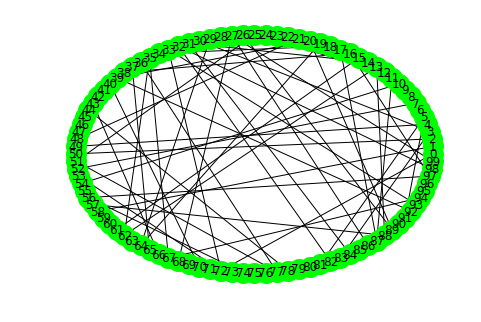

In [66]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

d_or_c = {0:'D',1:'C'}

# colors from our friends at http://colorbrewer2.org
COLORS = dict([(1,'#00ff00'),(0,'#0000ff')])

bench = TestBench(1, 4, 'WS', c0=.9, N=10, M=10)

labels = {}
for i in range(bench.n):
    labels[i] = (d_or_c[bench.nodes[i].state], bench.nodes[i].score)

print(labels)
    

nx.draw_circular(bench.graph,
                 node_color=COLORS[1],
                 node_size=400,
                 with_labels=True)


for _ in range(3):
    bench.step()

    labels = {}
    for i in range(bench.n):
        labels[i] = (d_or_c[bench.nodes[i].state], bench.nodes[i].score)
    
    print(labels)